USING QSVC IN ORDER TO TEST STANDARD QUANTUM KERNEL APPROACH

In [1]:
#needed to import qke procedures
import sys
from pathlib import Path

main_dir = str(Path().resolve().parent)
sys.path.insert(1, main_dir)

In [2]:
#scikit learn and tools
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from qiskit_algorithms.utils import algorithm_globals

#set the seed(s)
np.random.seed(123)
algorithm_globals.random_seed = 123

#load dataset with panda
#data are scaled outside the notebook
env = pd.read_csv('../data/env.sel3.minmax.csv') 
#take a look of the dataset

print(f'DESCRIBE DATASET')
display(env.describe() )


#DEFINE design matrix
#slice dataset
f_rate = 0.05
env_slice = env.sample(frac=f_rate, random_state=123)

Y = env_slice['occupancy']
#X = env[['illuminance', 'blinds','lamps','co', 'rh', 'co2', 'temp']]
X = env_slice[['illuminance', 'blinds','lamps','rh', 'co2', 'temp']]

print(f'HEAD')
display(X.head())

DESCRIBE DATASET


,illuminance,blinds,lamps,rh,co2,temp,occupancy
count,2865.000000,2865.000000,2865.000000,2865.000000,2865.000000,2865.000000,2865.000000
mean,0.333425,2.518369,1.873848,1.852158,0.799182,1.270298,-0.130192
std,0.328082,1.169630,1.537233,0.645917,0.653629,0.715849,0.991662
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.052071,3.141593,0.000000,1.533741,0.244120,0.659075,-1.000000
50%,0.310495,3.141593,3.141593,1.996120,0.586569,1.131413,-1.000000
75%,0.443564,3.141593,3.141593,2.261947,1.293940,1.790488,1.000000
max,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,1.000000


HEAD


,illuminance,blinds,lamps,rh,co2,temp
1618,0.312424,3.141593,3.141593,2.158032,1.134938,0.629783
610,0.842772,3.141593,3.141593,0.600125,0.274742,1.980888
1667,0.015428,3.141593,0.000000,2.349750,0.874522,0.659075
2481,0.289281,0.000000,3.141593,2.404527,1.192528,0.252645
2638,0.190926,3.141593,0.000000,2.138700,1.106006,0.849475


In [7]:
#split design matrix (25% of the design matrix used for test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=123)

#cast to numpy object
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

NUM_QUBIT =  X_train.shape[1]
#sanity check
print(f'TRAIN***** {X_train.shape}')
print(f'TEST***** {X_test.shape}')
print(f'Number of Qbit:  {NUM_QUBIT}')

TRAIN***** (107, 6)
TEST***** (36, 6)
Number of Qbit:  6


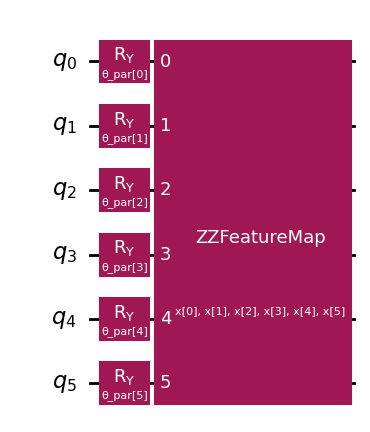

In [ ]:
from pqk.Circuits import Circuits


encoding_circuit = Circuits.zzfeaturemap(n_wire=NUM_QUBIT)
trainable_circuit = Circuits.x_encoded(n_wire=NUM_QUBIT, full_ent=False)
encoding_circuit.barrier()
fm = encoding_circuit.compose(trainable_circuit)
training_params = trainable_circuit.parameters

fm.draw('mpl')

In [9]:
#define the trainable kernel
from pqk.CKernels import CKernels
from pqk.QMeasures import QMeasures
from pqk.TrainableKernelFeatureMap import TrainableKernelFeatureMap

my_obs = ['ZIIIII', 'IZIIII','IIZIII', 'IIIZII','IIIIZI','IIIIIZ']
nshots = 100 #paramenter using primitive estimator
measure_fn = QMeasures.StateVectorEstimator
kernel = CKernels.linear

#using kernel feature map (change the q_kernel in order to modiy the trainable kernel)
q_kernel = TrainableKernelFeatureMap(feature_map=fm, training_parameters=training_params)
q_kernel.configure(save_feature_map=False, obs=my_obs, nshots=nshots, q_measure=QMeasures.StateVectorEstimator, c_kernel=CKernels.rbf)


In [10]:
#get the optimized kernel
from qiskit_machine_learning.kernels.algorithms.quantum_kernel_trainer import QuantumKernelTrainer
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.utils.loss_functions import SVCLoss

#define the callback
from pqk.QKCallback import QKCallback
my_callback = QKCallback()


spsa_opt = SPSA(maxiter=20, learning_rate=0.03, perturbation=0.01, termination_checker=my_callback.callback)
loss_func = SVCLoss(C=1.0)

#one initial point per trainable parameter
#init_point=[np.pi/2]
init_point = np.random.uniform(size=NUM_QUBIT)

qk_trainer = QuantumKernelTrainer(quantum_kernel=q_kernel, loss=loss_func, initial_point= init_point, optimizer=spsa_opt)
qkt_results = qk_trainer.fit(X_train, y_train)

optimized_kernel = qkt_results.quantum_kernel

**********************
Print callback. Iteration 1
Number of function evaluations: 2
The paramenters: [ 0.98984226 -0.00723374 -0.06652162  0.2579417   0.4260959   0.71647953]
The function value: 67.2973453992822
The stepsize: 0.7186143279291218
Whether the step was accepted: True
**********************
**********************
Print callback. Iteration 2
Number of function evaluations: 4
The paramenters: [ 9.82127933e-01  4.80587964e-04 -7.42359412e-02  2.50227374e-01
  4.18381575e-01  7.24193855e-01]
The function value: 65.15767870518023
The stepsize: 0.018896157250250088
Whether the step was accepted: True
**********************
**********************
Print callback. Iteration 3
Number of function evaluations: 6
The paramenters: [ 0.97228276  0.01032576 -0.08408112  0.2403822   0.4085364   0.73403903]
The function value: 65.15538915754254
The stepsize: 0.02411565956538045
Whether the step was accepted: True
**********************
**********************
Print callback. Iteration 4
Numb

In [11]:
from qiskit_machine_learning.algorithms.classifiers import QSVC
qsvc = QSVC(quantum_kernel=optimized_kernel)

In [12]:
#trainingprediction...
qsvc.fit(X_train, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<pqk.TrainableKernelFeatureMap.TrainableKernelFeatureMap object at 0x723069edfe00>,
     random_state=123, shrinking=True, tol=0.001, verbose=False)

In [13]:
from sklearn.metrics import accuracy_score

#result...
predictions = qsvc.predict(X_test)
score = accuracy_score(predictions, y_test)

print(f'*******SCORE: {score}')


*******SCORE: 0.6666666666666666


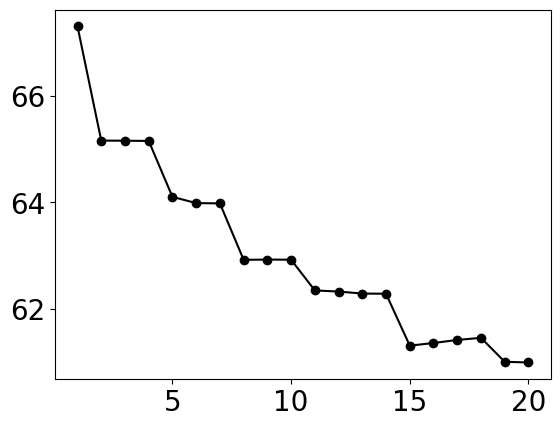

In [14]:
#plot data
my_callback.plot_data()